In [1]:
from dl_toolbox.lightning_modules import *
from dl_toolbox.lightning_datamodules import *
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer 
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
logger = TensorBoardLogger(
    '/d/pfournie/ai4geo/outputs',
    name='test_modules'
)

trainer = Trainer(
    max_epochs=100,
    logger=logger,
    gpus=1
)

dm = FromFolderDataset(
    folder_dataset='Resisc',
    data_path='/data/NWPU-RESISC45',
    epoch_len=500,
    batch_size=4,
    workers=6,
    train_idxs=[700*i+j for i in range(45) for j in range(50)],
    test_idxs=[700*i+j for i in range(45) for j in range(50,700)],
    unsup_train_idxs=[700*i+j for i in range(45) for j in range(100)],
    img_aug='d4',
    unsup_img_aug='color-5'
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
CKPT_PATH='/data/outputs/test_ce_resisc/version_6/checkpoints/epoch=49-step=182799.ckpt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CKPT_PATH, map_location=device)

module = CE(
    ignore_index=-1,
    network='Vgg',
    weights=[],
    in_channels=3,
    out_channels=45,
    initial_lr=0.001,
    final_lr=0.0005,
    class_names=dm.val_set.dataset.class_names,
)

module.load_state_dict(ckpt['state_dict'])
module.to(device);

#trainer.fit(
#    model=module,
#    datamodule=dm,
#)

Text(0.5, 1.0, '/data/NWPU-RESISC45/wetland/wetland_700.jpg, pred=wetland')

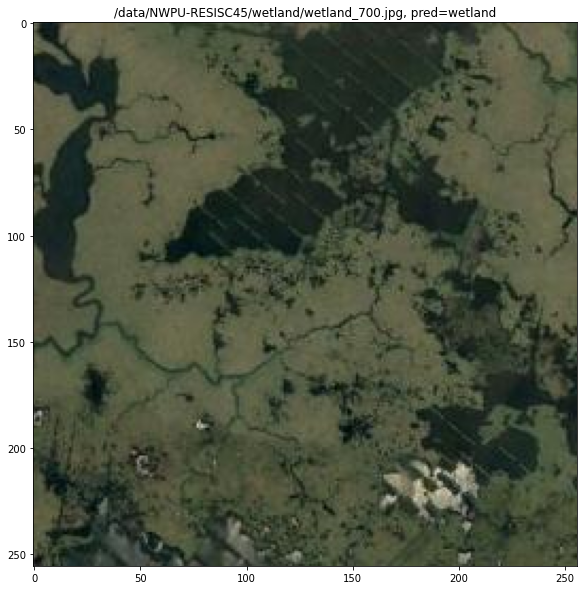

In [19]:
module.eval()
elem = dm.val_set.dataset[-1]
inputs = elem['image'].unsqueeze(0).to(device)
logits = module(inputs)
probas = module._compute_probas(logits)
conf, pred = module._compute_conf_preds(probas)
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(elem['image'].numpy().transpose(1,2,0))
ax.set_title(elem['path']+', pred='+dm.val_set.dataset.classes[int(pred)])

In [20]:
def fgsm_attack(model, loss, images, labels, eps):
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    #attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'adv img, pred=forest')

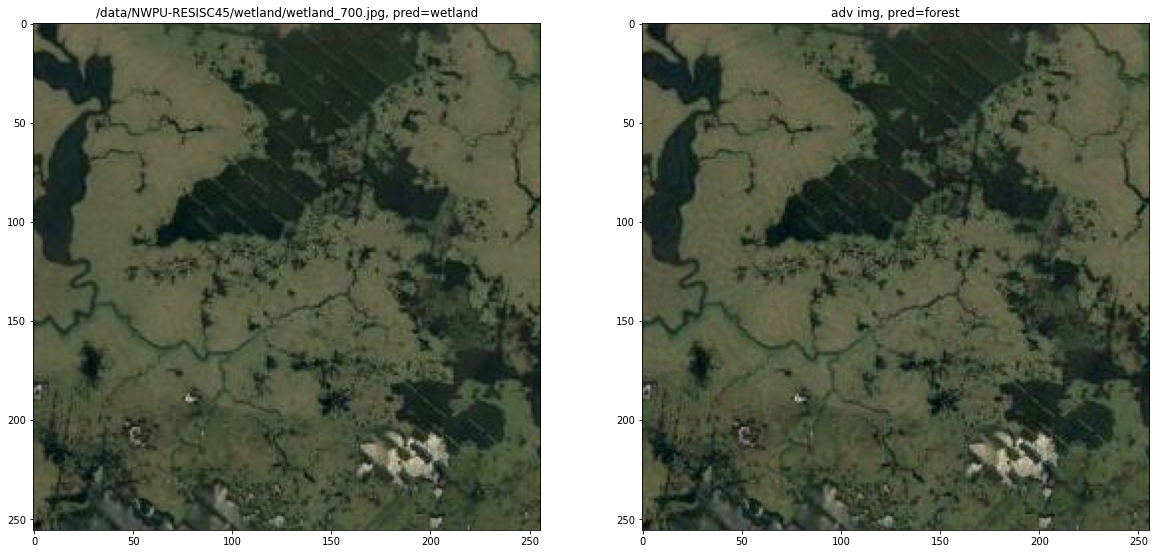

In [21]:
loss = torch.nn.CrossEntropyLoss()
module.eval()
adv_img = fgsm_attack(
    module,
    loss,
    elem['image'].unsqueeze(0),
    elem['mask'].unsqueeze(0),
    eps=0.01
).to(device)
adv_logits = module(adv_img.contiguous())
adv_probas = module._compute_probas(adv_logits)
adv_conf, adv_pred = module._compute_conf_preds(adv_probas)

f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(elem['image'].numpy().transpose(1,2,0))
ax[0].set_title(elem['path']+', pred='+dm.val_set.dataset.classes[int(pred)])
ax[1].imshow(adv_img.detach().cpu().numpy().squeeze().transpose(1,2,0))
ax[1].set_title('adv img, pred='+dm.val_set.dataset.classes[int(adv_pred)])

In [22]:
import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F


@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d

def vat_attack(model, x, xi, eps, ip):
    
    x=x.to(device)
    
    with torch.no_grad():
        pred = F.softmax(model(x), dim=1)
    
    # prepare random unit tensor
    d = torch.rand(x.shape).sub(0.5).to(x.device)
    d = _l2_normalize(d)
    
    with _disable_tracking_bn_stats(model):
        # calc adversarial direction
        for _ in range(ip):
            d.requires_grad_()
            pred_hat = model(x + xi * d)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
            adv_distance.backward()
            d = _l2_normalize(d.grad)
            model.zero_grad()
            
        r_adv = d * eps
        
    return x+r_adv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'adv img, pred=forest')

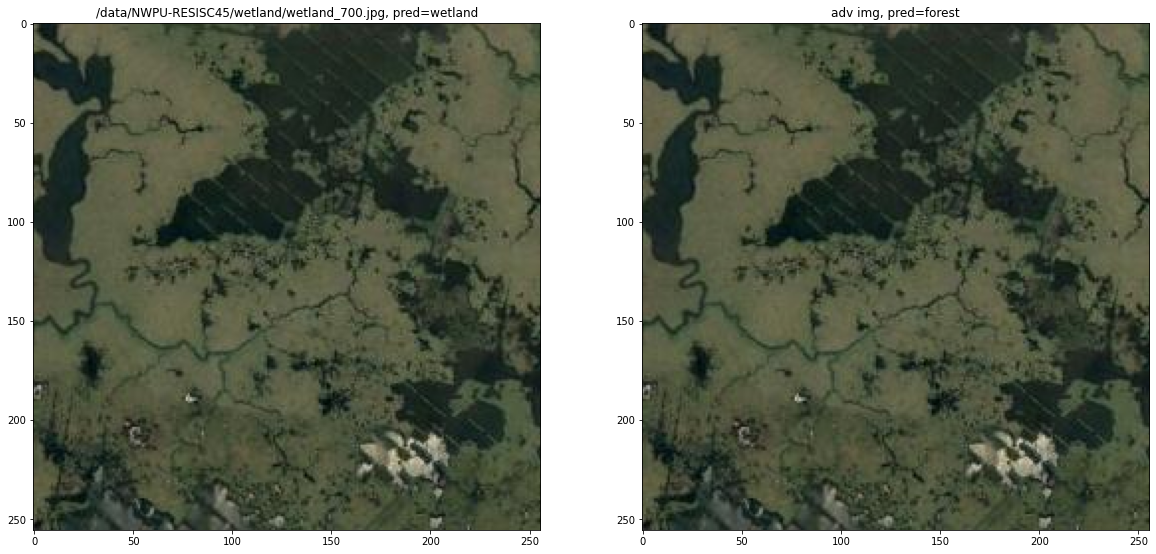

In [24]:
adv_img = vat_attack(
    module,
    elem['image'].unsqueeze(0),
    10.,
    1.,
    1
).to(device)
adv_logits = module(adv_img.contiguous())
adv_probas = module._compute_probas(adv_logits)
adv_conf, adv_pred = module._compute_conf_preds(adv_probas)

f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(elem['image'].numpy().transpose(1,2,0))
ax[0].set_title(elem['path']+', pred='+dm.val_set.dataset.classes[int(pred)])
ax[1].imshow(adv_img.detach().cpu().numpy().squeeze().transpose(1,2,0))
ax[1].set_title('adv img, pred='+dm.val_set.dataset.classes[int(adv_pred)])